In [1]:
import os

# --- Add these lines at the very top of your script ---
# This must be done BEFORE importing numpy or other scientific libraries.
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
import time
from device import Device

from hamiltonian import Hamiltonian
from device import Device

import scipy as sp
from hamiltonian import Hamiltonian
from helper import Helper_functions
import scipy.sparse as spa
import numpy as np
import scipy.sparse as sp
from lead_self_energy import LeadSelfEnergy
from scipy.sparse import bmat, identity, random, csc_matrix
from scipy.sparse.linalg import eigsh, eigs, spsolve
import time
from charge import Charge

In [2]:
dev = Device(2e-9, 1e-9)
ham = Hamiltonian(dev)
chargeObj = Charge(dev)
energy_range = np.linspace(-10, 10, 150)


In [ ]:
electrons = chargeObj.calculate_smeared_electron_density()

In [ ]:
electrons

In [ ]:
N_atoms = len(ham.unitCell.ATOM_POSITIONS)
LDOS = np.zeros(N_atoms)

for e in energy_range:
    L = chargeObj.calculate_LDOS(e)
    ldos = L.values()
    print(ldos)
    LDOS += list(ldos) 

In [ ]:
total_LDOS_per_atom = {}
for atom, ld in zip(ham.unitCell.ATOM_POSITIONS, LDOS):
    total_LDOS_per_atom[atom] = ld
print(total_LDOS_per_atom)

In [ ]:


LDOS = np.zeros((dev.nx, dev.nz))

for e in energy_range:
    L = chargeObj.calculate_LDOS(e)
    D = chargeObj.unsmear_to_smear(L)
    LDOS += D

In [ ]:
LDOS / 100
def plot_2d_array(data, Lx, Lz):

    if not isinstance(data, np.ndarray) or data.ndim != 2:
        raise ValueError("Input 'data' must be a 2D numpy array.")
    
    print(f"Plotting array of shape {data.shape} over domain X=[0, {Lx}], Z=[0, {Lz}]")
    plt.figure(figsize=(10, 6))

    im = plt.imshow(data, extent=[0, Lx, 0, Lz], origin='lower', aspect='auto', cmap='viridis')

    plt.colorbar(im, label='LDOS')

    plt.xlabel(f'X-axis (0 to {Lx})')
    plt.ylabel(f'Z-axis (0 to {Lz})')
    plt.title('2D Array Visualization')
    plt.tight_layout()

    plt.show()

plot_2d_array(LDOS, 2e-9, 1e-9)

In [3]:
dev = Device(2e-9, 1e-9)
ham = Hamiltonian(dev)
chargeObj = Charge(dev)
energy_range = np.linspace(-10, 10, 150)


In [8]:
LDOS = chargeObj.calculate_smeared_LDOS(1)

Calculating LDOS at E=1.000 eV


Plotting array of shape (40, 50) over domain X=[0, 2e-09], Z=[0, 1e-09]


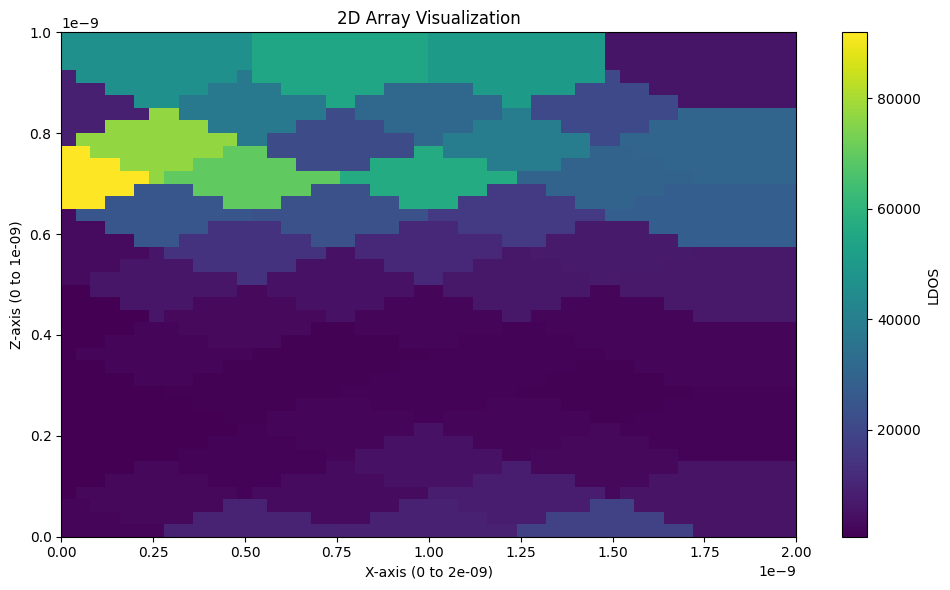

In [9]:
def plot_2d_array(data, Lx, Lz):

    if not isinstance(data, np.ndarray) or data.ndim != 2:
        raise ValueError("Input 'data' must be a 2D numpy array.")
    
    print(f"Plotting array of shape {data.shape} over domain X=[0, {Lx}], Z=[0, {Lz}]")
    plt.figure(figsize=(10, 6))

    im = plt.imshow(data, extent=[0, Lx, 0, Lz], origin='lower', aspect='auto', cmap='viridis')

    plt.colorbar(im, label='LDOS')

    plt.xlabel(f'X-axis (0 to {Lx})')
    plt.ylabel(f'Z-axis (0 to {Lz})')
    plt.title('2D Array Visualization')
    plt.tight_layout()

    plt.show()

plot_2d_array(LDOS, 2e-9, 1e-9)

In [3]:
electrons = chargeObj.calculate_total_electron_density()

Calculating total electron density with 100 energy points
Starting density calculations for 3200 (E, ky) pairs...
Total density calculation completed in 86.93 seconds
Total density calculation completed in 86.93 seconds


In [4]:
electrons

{(0.0, 0, 0): np.float64(4.006503692579622e-13),
 (0.0, 0.5, 0.5): np.float64(8.9515375291076e-13),
 (0.0, 0, 1): np.float64(1.462134728708427e-12),
 (0.0, 0.5, 1.5): np.float64(2.322669381622829e-12),
 (0.25, 0.25, 0.25): np.float64(7.594016743860307e-13),
 (0.25, 0.75, 0.75): np.float64(1.5396400389835685e-12),
 (0.25, 0.25, 1.25): np.float64(2.447358435732304e-12),
 (0.25, 0.75, 1.75): np.float64(2.5666034904981916e-12),
 (0.5, 0.5, 0): np.float64(1.1624643441303413e-12),
 (0.5, 0, 0.5): np.float64(8.087087996065491e-13),
 (0.5, 0.5, 1): np.float64(1.6481854097633465e-12),
 (0.5, 0, 1.5): np.float64(5.0204921807096915e-12),
 (0.75, 0.75, 0.25): np.float64(2.038200266385451e-12),
 (0.75, 0.25, 0.75): np.float64(2.721880494288641e-12),
 (0.75, 0.75, 1.25): np.float64(5.338589234980834e-12),
 (0.75, 0.25, 1.75): np.float64(5.5907167917984465e-12),
 (1.0, 0, 0): np.float64(4.091562588205119e-12),
 (1.0, 0.5, 0.5): np.float64(3.516333580389465e-12),
 (1.0, 0, 1): np.float64(4.23821363067